<a href="https://colab.research.google.com/github/vijaygwu/SEAS8525/blob/main/Class_2_CL_SimpleOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

170498071/170498071 [==============================] - 6s 0us/step

Start of epoch 0


Training loss (for one batch) at step 0: 5.391702175140381
Training loss (for one batch) at step 100: 1.237807035446167

Start of epoch 1
Training loss (for one batch) at step 0: 1.191774845123291
Training loss (for one batch) at step 100: 1.1408979892730713

Start of epoch 2
Training loss (for one batch) at step 0: 1.158057451248169
Training loss (for one batch) at step 100: 1.1201800107955933

Start of epoch 3
Training loss (for one batch) at step 0: 1.1260020732879639
Training loss (for one batch) at step 100: 1.1050447225570679

Start of epoch 4
Training loss (for one batch) at step 0: 1.1152527332305908
Training loss (for one batch) at step 100: 1.105237603187561

Start of epoch 5
Training loss (for one batch) at step 0: 1.1008955240249634
Training loss (for one batch) at step 100: 1.0894161462783813

Start of epoch 6
Training loss (for one batch) at step 0: 1.1006823778152466
Training loss (for one batch) at step 100: 1.0880064964294434

Start of epoch 7
Training loss (for one ba

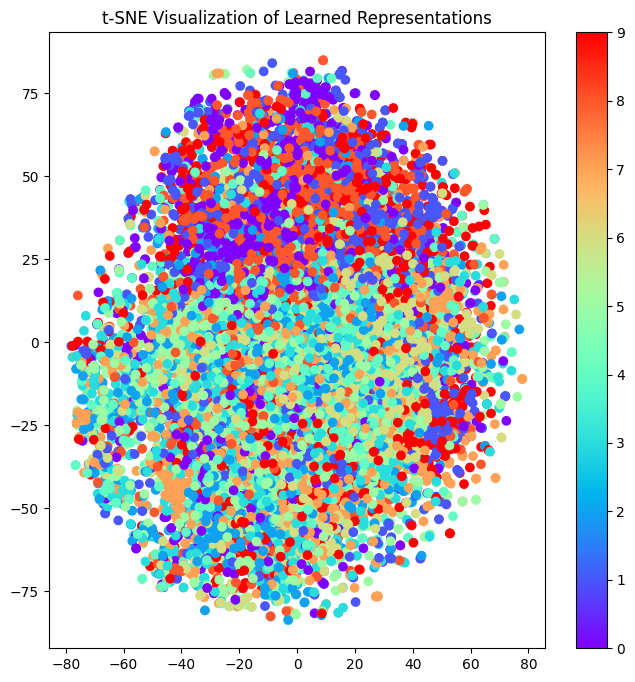

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load and preprocess the CIFAR-10 dataset
(x_train, _), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Pre-scaled data

# Define the data augmentation function and apply it to the training dataset
data_augmentation = keras.Sequential([
    layers.RandomCrop(height=32, width=32),
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
])

batch_size = 256

# Convert the training data into a TensorFlow Dataset, apply augmentation, cache and prefetch
train_dataset = tf.data.Dataset.from_tensor_slices(x_train)
train_dataset = train_dataset.map(lambda x: data_augmentation(x, training=True), num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# Define the base encoder network
def create_encoder():
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu')(x)
    x = layers.GlobalMaxPooling2D()(x)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

# Define the projection head
def create_projection_head():
    inputs = keras.Input(shape=(128,))
    x = layers.Dense(256, activation='relu')(inputs)
    outputs = layers.Dense(128)(x)
    return keras.Model(inputs=inputs, outputs=outputs)

encoder = create_encoder()
projection_head = create_projection_head()

optimizer = keras.optimizers.Adam()
epochs = 100
temperature = 0.2

# Custom training loop
for epoch in range(epochs):
    print(f"\nStart of epoch {epoch}")
    for step, x_batch_train in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # Forward pass
            encoded = encoder(x_batch_train, training=True)
            projected = projection_head(encoded, training=True)
            normalized = tf.math.l2_normalize(projected, axis=1)
            cosine_similarity = tf.matmul(normalized, normalized, transpose_b=True)
            logits = cosine_similarity / temperature
            labels = tf.range(x_batch_train.shape[0])
            loss_value = keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
            loss_value = tf.reduce_mean(loss_value)

        gradients = tape.gradient(loss_value, encoder.trainable_weights + projection_head.trainable_weights)
        optimizer.apply_gradients(zip(gradients, encoder.trainable_weights + projection_head.trainable_weights))

        if step % 100 == 0:
            print(f"Training loss (for one batch) at step {step}: {float(loss_value)}")

# Extract representations after training
representations = encoder.predict(x_test)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000)
tsne_results = tsne.fit_transform(representations)

plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test.flatten(), cmap='rainbow')
plt.title('t-SNE Visualization of Learned Representations')
plt.colorbar()
plt.show()


The SimCLR approach aims to learn meaningful representations of images in a self-supervised manner. It does this by maximizing the cosine similarity between representations of augmented views of the same image (positive pairs) and minimizing the cosine similarity between representations of different images (negative pairs). The contrastive loss encourages the encoder to learn representations that are invariant to the applied data augmentations.

The visualization using t-SNE allows us to assess the quality of the learned representations by observing how well the different classes are separated in the low-dimensional space.



This code demonstrates the implementation of a self-supervised learning approach called SimCLR (Simple Framework for Contrastive Learning of Visual Representations) using the CIFAR-10 dataset.


1. Importing Libraries:
   - The necessary libraries, including TensorFlow, Keras, Matplotlib, and scikit-learn, are imported.

2. Loading and Preprocessing Data:
   - The CIFAR-10 dataset is loaded using `keras.datasets.cifar10.load_data()`.
   - The pixel values of the training and testing data are divided by 255.0 to scale them to the range [0, 1].

3. Data Augmentation:
   - A data augmentation pipeline is defined using `keras.Sequential()` to apply random cropping, flipping, and zooming to the input images.
   - The training data is converted into a TensorFlow Dataset using `tf.data.Dataset.from_tensor_slices()`.
   - The data augmentation pipeline is applied to each example in the dataset using `map()`.
   - The dataset is batched, cached, and prefetched for efficient training.

4. Defining the Encoder Network:
   - The `create_encoder` function defines the base encoder network using convolutional layers, max pooling, and a global max pooling layer.
   - The encoder network takes an input image and outputs a 128-dimensional feature representation.

5. Defining the Projection Head:
   - The `create_projection_head` function defines the projection head network using dense layers.
   - The projection head takes the 128-dimensional feature representation from the encoder and projects it to a 128-dimensional space.

6. Training Loop:
   - The training loop runs for a specified number of epochs.
   - For each batch of training data:
     - The encoder and projection head are applied to the batch of images.
     - The resulting projected representations are L2-normalized.
     - The cosine similarity matrix is computed between the normalized representations.
     - The contrastive loss is calculated using the cosine similarity matrix and temperature scaling.
     - The gradients of the loss with respect to the weights of the encoder and projection head are computed.
     - The optimizer is used to update the weights of the encoder and projection head.

7. Extracting Representations:
   - After training, the trained encoder is used to extract representations (embeddings) for the test images.

8. t-SNE Visualization:
   - The t-SNE algorithm is used to reduce the dimensionality of the learned representations to 2D.
   - The t-SNE results are plotted using Matplotlib, with each point colored according to its true class label.



Compared to the previous code, this version includes a few optimizations:
- The data is pre-scaled by dividing by 255.0 before creating the dataset.
- The data augmentation pipeline is applied using `map()` on the dataset, which can be more efficient than applying it during the training loop.
- The dataset is cached and prefetched to optimize data loading and processing during training.

These optimizations can help improve the training speed and efficiency of the SimCLR model.